In [11]:
using Dates
using LinearAlgebra
using SparseArrays
using TensorOperations
using Plots
using Printf 

### Motivation

The following notebook works through three methods &mdash; iterative diagonalization, truncated iterative diagonalization, and density matrix renormalization group (DMRG) &mdash; to find the the ground state energy of a spin-1 Heisenberg chain with open boundary conditions and nearest neighbor interactions. The varying accuracy and convergence times for the three method are compared, illustrating the relative performances.


### 1D chain of Spin-1 particles - Classical Heisenberg Model

A 1D spin chain with open boundary conditions and nearest neighbor interactions for spin-1 particles with coupling strength J is illustrated below.

<img src="./img/spin-1%20chain.png" alt="spin-1 chain" width="50%" style="display: block; margin-left: auto; margin-right: auto;"/>

The model is described by the following Hamiltonian,

$$\mathcal{H} = J \sum_{i=1}^{N-1} \vec{S}_i \cdot \vec{S}_{i+1},$$

where $N$ is the number of spins and $\vec{S}_j = (S^x_j, S^y_j, S^z_j)$ is the vector of spin-1 operators at site $j$.

Introducing the usual raising and lowering operators $S^\pm = S^x \pm iS^y$ and considering the basis $\{ |s^z_j\rangle \} = \{ |1\rangle,|0\rangle,|-1\rangle \}$, such that

\begin{align*}
 S^+ |1\rangle &= 0 \qquad & S^+ |0\rangle &= |1\rangle \qquad & S^+ |-1\rangle &= |0\rangle \\
S^- |1\rangle &= |0\rangle\qquad &   S^- |0\rangle &= |-1\rangle \qquad & S^- |-1\rangle &= 0,
\end{align*}

the above Hamiltonian can be rewritten as

$$\mathcal{H} = J \sum_{j=1}^{N-1} \frac{1}{2} \left( S^+_j S^-_{j+1} + S^-_j S^+_{j+1} \right) +  S^z_j S^z_{j+1}.$$

In the $|s^z\rangle$ basis the operators $S^+, S^-,$ and $S^z$ have the folloing representation,

$$S^+ = \sqrt{2} \begin{pmatrix} 0 & 1 & 0 \\ 0 & 0 & 1 \\ 0 & 0 & 0 \end{pmatrix}, \quad S^- = \sqrt{2} \begin{pmatrix} 0 & 0 & 0 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{pmatrix}, \quad S^z = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & -1 \end{pmatrix}.$$

In [20]:
# Defining the spin-1 operators

## Sz
Sz = zeros(3, 3)
Sz[1, 1] = 1
Sz[3, 3] = -1

## Sp
Sp = zeros(3, 3)
Sp[1, 2] = sqrt(2)
Sp[2, 3] = sqrt(2)

## Sm
Sm = zeros(3, 3)
Sm[2, 1] = sqrt(2)
Sm[3, 2] = sqrt(2)

## I
I = Matrix(Diagonal(ones(3)));

### Iterative diagonalization

Here we detail the calculation of the ground state energy for spin-1 Heisenberg chains using iterative diagonalization. This approach yields exact results, limited only by machine precision, as it avoids any truncation of the Hilbert space. However, the exponential growth of the Hilbert space dimension restricts its applicability to short chain lengths.

Connecting iterative diagonalization to DMRG, the following simulation begins with two spin-1 particles, one for each of the system (S) and environment (E) blocks. With each iteration two particles are added, one to each block. The following depicts a full iteration, with the superblock labeled SB. Source ([Density-matrix renormalization group: a pedagogical introduction](https://arxiv.org/pdf/2304.13395))

<br>

<img src="./img/ID_scheme.png" alt="ID scheme" width="50%" style="display: block; margin-left: auto; margin-right: auto;"/>


In [8]:
# Parameters
Nit = 3  # number of iterations

# Iterative diagonalization
start_time = now()
I_S = I
H_S = zeros(size(I_S))
Szborder_S = Sz
Spborder_S = Sp
Smborder_S = Sm
I_E = I
H_E = zeros(size(I_E))
Szborder_E = Sz
Spborder_E = Sp
Smborder_E = Sm
I_L = I
H_L = zeros(size(I_L))
Szborder_L = Sz
Spborder_L = Sp
Smborder_L = Sm
I_R = I
H_R = zeros(size(I_R))
Szborder_R = Sz
Spborder_R = Sp
Smborder_R = Sm

for k in 1:Nit
    if k > 1  # remaining iterations
        I_S = I_L
        H_S = H_L
        Szborder_S = Szborder_L
        Spborder_S = Spborder_L
        Smborder_S = Smborder_L

        I_E = I_R
        H_E = H_R
        Szborder_E = Szborder_R
        Spborder_E = Spborder_R
        Smborder_E = Smborder_R
    end

    ## L = S x l
    I_L = kron(I_S, I)
    H_L = kron(H_S, I) + kron(Szborder_S, Sz) + 0.5 * (kron(Spborder_S, Sm) + kron(Smborder_S, Sp))
    Szborder_L = kron(I_S, Sz)
    Spborder_L = kron(I_S, Sp)
    Smborder_L = kron(I_S, Sm)

    ## R = r x E
    I_R = kron(I, I_E)
    H_R = kron(I, H_E) + kron(Sz, Szborder_E) + 0.5 * (kron(Sp, Smborder_E) + kron(Sm, Spborder_E))
    Szborder_R = kron(Sz, I_E)
    Spborder_R = kron(Sp, I_E)
    Smborder_R = kron(Sm, I_E)

    ## SB = L x R
    H_SB = kron(H_L, I_R) + kron(I_L, H_R) + kron(Szborder_L, Szborder_R) + 0.5 * (kron(Spborder_L, Smborder_R) + kron(Smborder_L, Spborder_R))

    ## diagonalization
    eigenvalues = eigvals(Hermitian(H_SB))
    sort!(eigenvalues)
    En = eigenvalues

    ## outputs
    Nspins = 2 + 2 * k
    println("#spins = ", Nspins)
    Egs = En[1]
    println("GS energy = ", Egs)
    println("dim of SB = ", size(H_SB, 1))
    time_elapsed = Dates.value(now() - start_time) / 1000.0
    println("time of iteration (s) = ", time_elapsed)
    start_time = now()
    println("\n")
end

#spins = 4
GS energy = -4.6457513110645925
dim of SB = 81
time of iteration (s) = 1.354


#spins = 6
GS energy = -7.370274969424611
dim of SB = 729
time of iteration (s) = 0.037


#spins = 8
GS energy = -10.124637222358913
dim of SB = 6561
time of iteration (s) = 18.561




### Truncated iterative diagonalization

Instead of keeping the full Hilbert space as done in iterative diagonalization, we now truncate each L and R block by projecting to the basis spanned by the $D$ lowest-energy states of the L and R blocks. This low rank representation of each block allows for increased computation speed and simluation of longer spin chains. 

Each new L and R block is truncated by forming a change of basis matrix $O_{L/R}$ from the $D$ eigenvectors of lowest energy of the L or R blocks from the previous iteration. 

$$\mathcal{H_{\textnormal{new S/E}}} = O_{L/R}H_{L/R}O^\dag_{L/R}.$$

<br>

<img src="./img/TID_scheme.png" alt="TID scheme" width="50%" style="display: block; margin-left: auto; margin-right: auto;"/>



Of note about eigenvalue degeneracies, when forming the change of basis matrices $O_{L/R}$, we must ensure that we keep all the degenerate states. The following code checks if there are degenerate states being discarded for a given choice of $D$ and, if so, these will be included at the expense of a slower diagonalization on that iteration.


Running TID with D = 9
D = 9, #spins = 4, GS energy per spin = -1.1614378277661481
D = 9, #spins = 6, GS energy per spin = -1.2283791615707698
D = 9, #spins = 8, GS energy per spin = -1.263878363833294
D = 9, #spins = 10, GS energy per spin = -1.2767458956815516
D = 9, #spins = 12, GS energy per spin = -1.2794666646960196
D = 9, #spins = 14, GS energy per spin = -1.2879161677460946
D = 9, #spins = 16, GS energy per spin = -1.2901547736981256
D = 9, #spins = 18, GS energy per spin = -1.2937552034167759
D = 9, #spins = 20, GS energy per spin = -1.2947477460129
D = 9, #spins = 22, GS energy per spin = -1.2960492653608933
D = 9, #spins = 24, GS energy per spin = -1.2962312461325467
D = 9, #spins = 26, GS energy per spin = -1.296411683701434
D = 9, #spins = 28, GS energy per spin = -1.2960905139630248
D = 9, #spins = 30, GS energy per spin = -1.2956944150726146
D = 9, #spins = 32, GS energy per spin = -1.2950575874291854
D = 9, #spins = 34, GS energy per spin = -1.2943404431249743
D = 9, #s

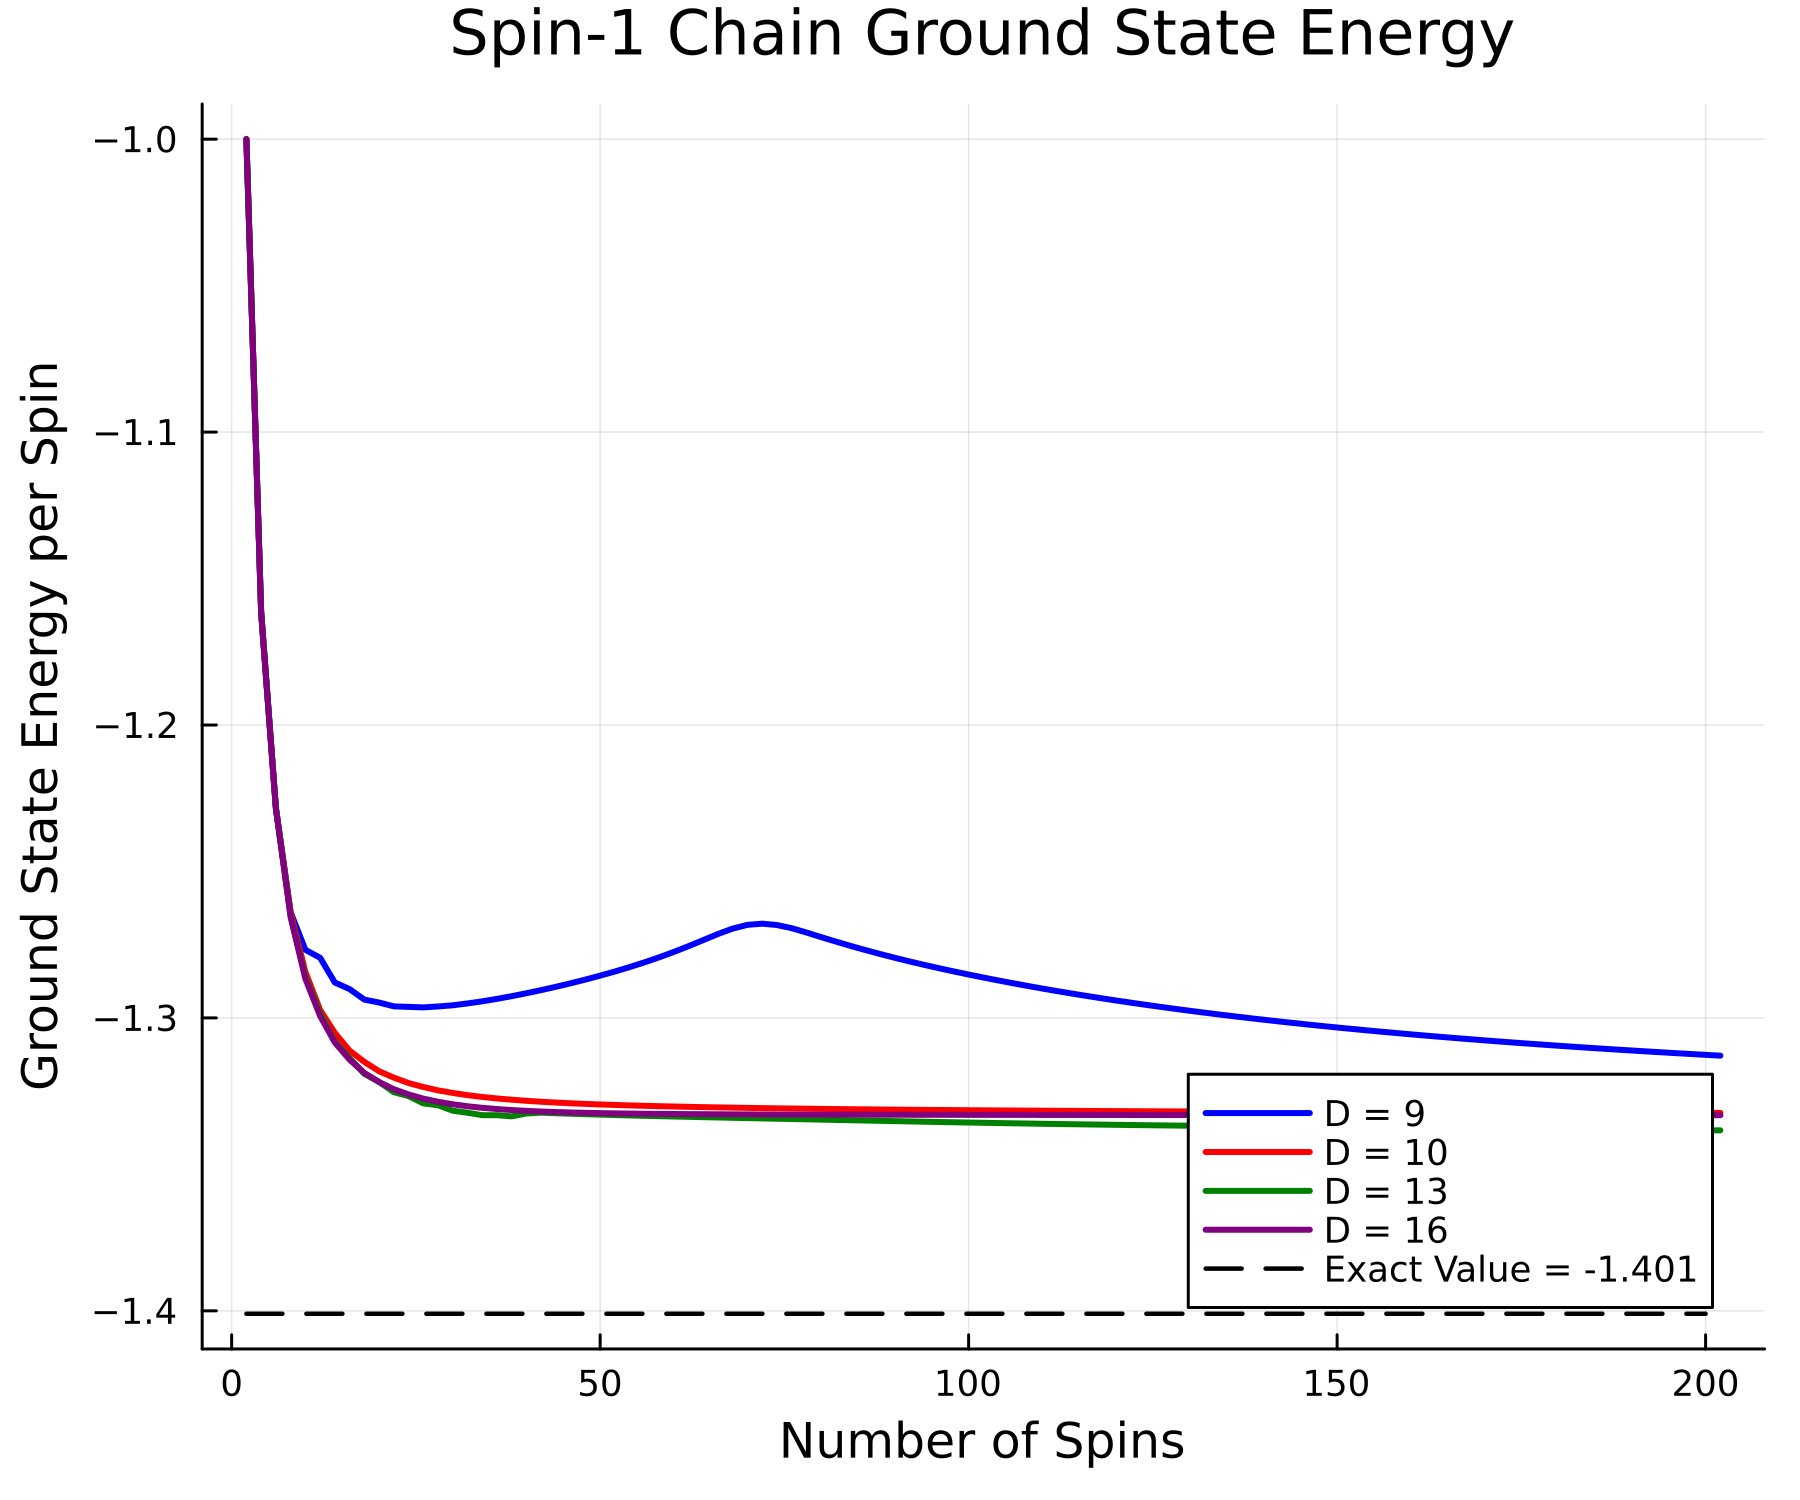

In [ ]:
function run_tid(D_value, max_iterations=2)
    # Parameters
    Nit = max_iterations # number of iterations
    D = D_value # maximum dimension for truncation
    tol_deg = 1e-10 # tolerance for degeneracies
    
    # # Defining the spin-1 operators
    # ## Sz
    # Sz = zeros(3, 3)
    # Sz[1, 1] = 1
    # Sz[3, 3] = -1
    # ## Sp
    # Sp = zeros(3, 3)
    # Sp[1, 2] = sqrt(2)
    # Sp[2, 3] = sqrt(2)
    # ## Sm
    # Sm = zeros(3, 3)
    # Sm[2, 1] = sqrt(2)
    # Sm[3, 2] = sqrt(2)
    # ## I
    # I = Matrix(Diagonal(ones(3)))
    
    # Arrays to store results
    spin_counts = Int[]
    ground_state_energies = Float64[]
    
    # Add the initial 2-spin system
    push!(spin_counts, 2)
    
    # Calculate the energy of the initial 2-spin system
    H_init = kron(Sz, Sz) + 0.5 * (kron(Sp, Sm) + kron(Sm, Sp))
    init_eigenvalues = eigvals(Hermitian(H_init))
    sort!(init_eigenvalues)
    push!(ground_state_energies, init_eigenvalues[1] / 2)  # per spin energy
    
    # Truncated iterative diagonalization
    start_time = now()
    
    # Initialize variables
    I_S = I
    H_S = zeros(size(I_S))
    Szborder_S = Sz
    Spborder_S = Sp
    Smborder_S = Sm
    
    I_E = I
    H_E = zeros(size(I_E))
    Szborder_E = Sz
    Spborder_E = Sp
    Smborder_E = Sm
    
    I_L = I
    H_L = zeros(size(I_L))
    Szborder_L = Sz
    Spborder_L = Sp
    Smborder_L = Sm
    
    I_R = I
    H_R = zeros(size(I_R))
    Szborder_R = Sz
    Spborder_R = Sp
    Smborder_R = Sm
    
    for k in 1:Nit
        if k > 1 # remaining iterations
            # Truncation by lowest-eigenvalues
            eigen_L = eigen(Hermitian(H_L))
            En_L = eigen_L.values
            psin_L = eigen_L.vectors
            O_L = psin_L[:, 1:min(D, length(En_L))]'
            
            # Handle degenerate states for O_L
            lines_O_L = size(O_L, 1)
            for it in (lines_O_L + 1):length(En_L)
                if abs(En_L[lines_O_L] - En_L[it]) < tol_deg
                    O_L = vcat(O_L, psin_L[:, it]')
                else
                    break
                end
            end
            
            eigen_R = eigen(Hermitian(H_R))
            En_R = eigen_R.values
            psin_R = eigen_R.vectors
            O_R = psin_R[:, 1:min(D, length(En_R))]'
            
            # Handle degenerate states for O_R
            lines_O_R = size(O_R, 1)
            for it in (lines_O_R + 1):length(En_R)
                if abs(En_R[lines_O_R] - En_R[it]) < tol_deg
                    O_R = vcat(O_R, psin_R[:, it]')
                else
                    break
                end
            end
            
            # S
            I_S = O_L * I_L * O_L'
            H_S = O_L * H_L * O_L'
            Szborder_S = O_L * Szborder_L * O_L'
            Spborder_S = O_L * Spborder_L * O_L'
            Smborder_S = O_L * Smborder_L * O_L'
            
            # E
            I_E = O_R * I_R * O_R'
            H_E = O_R * H_R * O_R'
            Szborder_E = O_R * Szborder_R * O_R'
            Spborder_E = O_R * Spborder_R * O_R'
            Smborder_E = O_R * Smborder_R * O_R'
        end
        
        # L = S x l
        I_L = kron(I_S, I)
        H_L = kron(H_S, I) + kron(Szborder_S, Sz) + 0.5 * (kron(Spborder_S, Sm) + kron(Smborder_S, Sp))
        Szborder_L = kron(I_S, Sz)
        Spborder_L = kron(I_S, Sp)
        Smborder_L = kron(I_S, Sm)
        
        # R = r x E
        I_R = kron(I, I_E)
        H_R = kron(I, H_E) + kron(Sz, Szborder_E) + 0.5 * (kron(Sp, Smborder_E) + kron(Sm, Spborder_E))
        Szborder_R = kron(Sz, I_E)
        Spborder_R = kron(Sp, I_E)
        Smborder_R = kron(Sm, I_E)
        
        # SB = L x R
        H_SB = kron(H_L, I_R) + kron(I_L, H_R) + kron(Szborder_L, Szborder_R) + 0.5 * (kron(Spborder_L, Smborder_R) + kron(Smborder_L, Spborder_R))
        
        # Diagonalization
        eigenvalues = eigvals(Hermitian(H_SB))
        sort!(eigenvalues)
        En = eigenvalues
        
        # Outputs
        spin_step = 2
        Nspins = 2 + spin_step * k
        Egs = En[1] / Nspins
        
        # Store results
        push!(spin_counts, Nspins)
        push!(ground_state_energies, Egs)
        
        println("D = $D, #spins = $Nspins, GS energy per spin = $Egs")
        
        # Optional memory cleanup for large systems
        if k < Nit && size(H_SB, 1) > 1000
            GC.gc()
        end
    end
    
    return spin_counts, ground_state_energies
end

# Main script
function main()
    plt = plot(
        xlabel="Number of Spins", 
        ylabel="Ground State Energy per Spin",
        title="Spin-1 Chain Ground State Energy",
        legend=:bottomright,
        grid=true,
        linewidth=2,
        size=(600, 500),
        dpi=300
    )
    
    # Define D values to test
    D_values = [9, 10, 13, 16]
    max_iter = 100
    
    # Colors for different D values
    colors = [:blue, :red, :green, :purple]

    # Run TID for each D value
    for (idx, D) in enumerate(D_values)
        println("Running TID with D = $D")
        spin_counts, energies = run_tid(D, max_iter)
        
        # Plot results for this D value
        plot!(plt, spin_counts, energies,
            label="D = $D",
            color=colors[idx],
            linewidth=2)
    end

    plot!(plt, [2, 200], [-1.401, -1.401],
        line=:dash,
        color=:black,
        linewidth=1.5,
        label="Exact Value = -1.401")

    # Save the plot
    savefig(plt, "spin1_chain_gs_energy.png")
    return plt
end

# Run the main function
main()

### Infinite-system DMRG

To avoid the truncation error of TID caused by locally optimizing for subsystem low-energy eigenstates, DMRG truncates the reduced density matrices, $\rho_{L}, \rho_{R}$ formed by taking the partial trace of the full SB density matrix, $\rho_{SB} = |\psi \rangle \langle \psi|$. 

$$\rho_{L} = Tr_R(\rho_{SB}), \quad \rho_{R} = Tr_L(\rho_{SB})$$


<img src="./img/iDMRG_scheme.png" alt="iDMRG scheme" width="50%" style="display: block; margin-left: auto; margin-right: auto;"/>


Working with the reduced denisty matrices, the truncation procedue keeps $D$ eigenvectors with the highest eigenvalues. This is in contrast to TID, which keeps the lowest eigenvalue states of the subsystem blocks. 

In [ ]:
function run_dmrg(D_value, max_iterations=2)
    # Parameters
    Nit = max_iterations # number of iterations
    D = D_value # maximum dimension for truncation
    tol_deg = 1e-10 # tolerance for degeneracies
    
    # Defining the spin-1 operators
    # Spin-1 operators
    Sz = zeros(3, 3); Sz[1, 1] = 1; Sz[3, 3] = -1
    Sp = zeros(3, 3); Sp[1, 2] = sqrt(2); Sp[2, 3] = sqrt(2)
    Sm = zeros(3, 3); Sm[2, 1] = sqrt(2); Sm[3, 2] = sqrt(2)
    I =  Matrix(Diagonal(ones(3)))
    
    # Arrays to store results
    spin_counts = Int[]
    ground_state_energies = Float64[]
    
    # Add the initial 2-spin system
    push!(spin_counts, 2)
    
    # Calculate the energy of the initial 2-spin system
    H_init = kron(Sz, Sz) + 0.5 * (kron(Sp, Sm) + kron(Sm, Sp))
    init_eigenvalues = eigvals(Hermitian(H_init))
    sort!(init_eigenvalues)
    push!(ground_state_energies, init_eigenvalues[1] / 2)  # per spin energy
    
    # DMRG
    start_time = now()
    
    # Initialize variables
    I_S = I
    H_S = zeros(size(I_S))
    Szborder_S = Sz
    Spborder_S = Sp
    Smborder_S = Sm
    
    I_E = I
    H_E = zeros(size(I_E))
    Szborder_E = Sz
    Spborder_E = Sp
    Smborder_E = Sm
    
    I_L = I
    H_L = zeros(size(I_L))
    Szborder_L = Sz
    Spborder_L = Sp
    Smborder_L = Sm
    
    I_R = I
    H_R = zeros(size(I_R))
    Szborder_R = Sz
    Spborder_R = Sp
    Smborder_R = Sm
    
    for k in 1:Nit
        if k > 1 # remaining iterations
            # DMRG truncation (highest-eigenvalues of reduced density matrix)
            # psi matrix
            dim_L = size(I_L, 1)
            dim_R = size(I_R, 1)
            psi_mat = reshape(psi, (dim_L, dim_R))
            
            # O_L
            psi_L = psi_mat' * conj.(psi_mat)
            eigen_L = eigen(Hermitian(psi_L))
            vals_L = eigen_L.values
            vecs_L = eigen_L.vectors
            kept_indices = sortperm(vals_L, rev=true)[1:min(D, length(vals_L))]
            O_L = vecs_L[:, kept_indices]'

            # degenerate states
            lines_O_L = size(O_L, 1)
            for it in lines_O_L:size(vals_L, 1)
                if abs(vals_L[end - lines_O_L] - vals_L[end - it]) < tol_deg
                    O_L = vcat(O_L, vecs_L[:, end - it]')
                else
                    break
                end
            
            # O_R
            psi_R = psi_mat' * conj.(psi_mat)
            eigen_R = eigen(Hermitian(psi_R))
            vals_R = eigen_R.values
            vecs_R = eigen_R.vectors
            # Get indices of the D largest eigenvalues (in descending order)
            kept_indices = sortperm(vals_R, rev=true)[1:min(D, length(vals_R))]
            # Create O_L directly with all needed eigenvectors
            O_R = vecs_R[:, kept_indices]'

            # degenerate states
            lines_O_R = size(O_R, 1)
            for it in lines_O_R:size(vals_R, 1)
                if abs(vals_R[end - lines_O_R] - vals_R[end - it]) < tol_deg
                    O_R = vcat(O_R, vecs_R[:, end - it]')
                else
                    break
                end
            
            # S
            I_S = O_L * I_L * O_L'
            H_S = O_L * H_L * O_L'
            Szborder_S = O_L * Szborder_L * O_L'
            Spborder_S = O_L * Spborder_L * O_L'
            Smborder_S = O_L * Smborder_L * O_L'
            
            # E
            I_E = O_R * I_R * O_R'
            H_E = O_R * H_R * O_R'
            Szborder_E = O_R * Szborder_R * O_R'
            Spborder_E = O_R * Spborder_R * O_R'
            Smborder_E = O_R * Smborder_R * O_R'
        end
        
        # L = S x l
        I_L = kron(I_S, I)
        H_L = kron(H_S, I) + kron(Szborder_S, Sz) + 0.5 * (kron(Spborder_S, Sm) + kron(Smborder_S, Sp))
        Szborder_L = kron(I_S, Sz)
        Spborder_L = kron(I_S, Sp)
        Smborder_L = kron(I_S, Sm)
        
        # R = r x E
        I_R = kron(I, I_E)
        H_R = kron(I, H_E) + kron(Sz, Szborder_E) + 0.5 * (kron(Sp, Smborder_E) + kron(Sm, Spborder_E))
        Szborder_R = kron(Sz, I_E)
        Spborder_R = kron(Sp, I_E)
        Smborder_R = kron(Sm, I_E)
        
        # SB = L x R
        H_SB = kron(H_L, I_R) + kron(I_L, H_R) + kron(Szborder_L, Szborder_R) + 0.5 * (kron(Spborder_L, Smborder_R) + kron(Smborder_L, Spborder_R))
        
        # Diagonalization
        En, psin = eigen(H_SB)
        # psi for density matrix
        psi = psin[:, 1]
        
        # Outputs
        spin_step = 2
        Nspins = 2 + spin_step * k
        Egs = En[1] / Nspins
        
        # Store results
        push!(spin_counts, Nspins)
        push!(ground_state_energies, Egs)
        
        println("D = $D, #spins = $Nspins, GS energy per spin = $Egs")
        
        # Optional memory cleanup for large systems
        if k < Nit && size(H_SB, 1) > 1000
            GC.gc()
        end
    end
    
    return spin_counts, ground_state_energies
end

# Main script
function main()
    plt = plot(
        xlabel="Number of Spins", 
        ylabel="Ground State Energy per Spin",
        title="Spin-1 Chain Ground State Energy",
        legend=:bottomright,
        grid=true,
        linewidth=2,
        size=(600, 500),
        dpi=300
    )
    
    # Define D values to test
    D_values = [4, 8, 12]
    max_iter = 100
    
    # Colors for different D values
    colors = [:blue, :red, :green, :purple]

    # Run DMRG for each D value
    for (idx, D) in enumerate(D_values)
        println("Running DMRG with D = $D")
        spin_counts, energies = run_dmrg(D, max_iter)
        
        # Plot results for this D value
        plot!(plt, spin_counts, energies,
            label="D = $D",
            color=colors[idx],
            linewidth=2)
    end

    plot!(plt, [2, 200], [-1.401, -1.401],
        line=:dash,
        color=:black,
        linewidth=1.5,
        label="Exact Value = -1.401")

    # Save the plot
    savefig(plt, "spin1_chain_gs_energy_dmrg.png")
    return plt
end

# Run the main function
main()

Base.Meta.ParseError: ParseError:
# Error @ /Users/williamhorvat/Desktop/tensor-networks/DMRG julia/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X13sZmlsZQ==.jl:209:7
# Run the main function
main()
#     └ ── Expected `end`

In [ ]:
function run_dmrg(D_value, max_iterations=20)
    # Parameters
    Nit = max_iterations
    D = D_value
    tol_deg = 1e-10

    # Spin-1 operators
    Sz = zeros(3, 3); Sz[1, 1] = 1; Sz[3, 3] = -1
    Sp = zeros(3, 3); Sp[1, 2] = sqrt(2); Sp[2, 3] = sqrt(2)
    Sm = zeros(3, 3); Sm[2, 1] = sqrt(2); Sm[3, 2] = sqrt(2)
    I =  Matrix(Diagonal(ones(3)))

    spin_counts = Int[]
    ground_state_energies = Float64[]
    push!(spin_counts, 2)

    # Initial 2-spin system
    H_init = kron(Sz, Sz) + 0.5 * (kron(Sp, Sm) + kron(Sm, Sp))
    init_eigenvalues = sort(eigvals(Hermitian(H_init)))
    push!(ground_state_energies, init_eigenvalues[1] / 2)

    # DMRG start
    I_S = I; H_S = zeros(size(I_S)); Szborder_S = Sz; Spborder_S = Sp; Smborder_S = Sm
    I_E = I; H_E = zeros(size(I_E)); Szborder_E = Sz; Spborder_E = Sp; Smborder_E = Sm
    I_L = I; H_L = zeros(size(I_L)); Szborder_L = Sz; Spborder_L = Sp; Smborder_L = Sm
    I_R = I; H_R = zeros(size(I_R)); Szborder_R = Sz; Spborder_R = Sp; Smborder_R = Sm

    for k in 1:Nit
        # L = S x l
        I_L = kron(I_S, I)
        H_L = kron(H_S, I) + kron(Szborder_S, Sz) + 0.5 * (kron(Spborder_S, Sm) + kron(Smborder_S, Sp))
        Szborder_L = kron(I_S, Sz)
        Spborder_L = kron(I_S, Sp)
        Smborder_L = kron(I_S, Sm)

        # R = r x E
        I_R = kron(I, I_E)
        H_R = kron(I, H_E) + kron(Sz, Szborder_E) + 0.5 * (kron(Sp, Smborder_E) + kron(Sm, Spborder_E))
        Szborder_R = kron(Sz, I_E)
        Spborder_R = kron(Sp, I_E)
        Smborder_R = kron(Sm, I_E)

        # SB = L x R
        H_SB = kron(H_L, I_R) + kron(I_L, H_R) +
            kron(Szborder_L, Szborder_R) +
            0.5 * (kron(Spborder_L, Smborder_R) + kron(Smborder_L, Spborder_R))

        # Diagonalize SB to get psi before using it
        eigen_SB = eigen(Hermitian(H_SB))
        En = eigen_SB.values
        psin = eigen_SB.vectors
        psi = psin[:, 1]

        if k > 1
            dim_L = size(I_L, 1)
            dim_R = size(I_R, 1)
            psi_mat = reshape(psi, (dim_L, dim_R))
            println("psi dims are $dim_L, $dim_R")

            # Left block
            psi_L = psi_mat * psi_mat'
            psi_L_dim1 = size(psi_L, 1)
            psi_L_dim2 = size(psi_L, 1)
            println("psi_L dims are $psi_L_dim1, $psi_L_dim2")

            eigen_L = eigen(Hermitian(psi_L))
            vals_L = eigen_L.values
            vecs_L = eigen_L.vectors
            kept_indices = sortperm(vals_L, rev=true)[1:min(D, length(vals_L))]
            O_L = vecs_L[:, kept_indices]
            O_L_dim1 = size(O_L, 1)
            O_L_dim2 = size(O_L, 2)
            println("O_L dims are $O_L_dim1, $O_L_dim2")

            last_kept_val = vals_L[sortperm(vals_L, rev=true)[D]]
            for i in 1:length(vals_L)
                if vals_L[i] ≈ last_kept_val && !(vecs_L[:, i] in eachcol(O_L))
                    O_L = hcat(O_L, vecs_L[:, i])
                end
            end
            O_L_dim1_1 = size(O_L, 1)
            O_L_dim2_1 = size(O_L, 2)
            println("O_L_1 dims are $O_L_dim1_1, $O_L_dim2_1")

            # Right block (same fix as left)
            psi_R = psi_mat' * psi_mat
            eigen_R = eigen(Hermitian(psi_R))
            vals_R = eigen_R.values
            vecs_R = eigen_R.vectors
            kept_indices = sortperm(vals_R, rev=true)[1:min(D, length(vals_R))]
            O_R = vecs_R[:, kept_indices]

            last_kept_val = vals_R[sortperm(vals_R, rev=true)[D]]
            for i in 1:length(vals_R)
                if vals_R[i] ≈ last_kept_val && !(vecs_R[:, i] in eachcol(O_R))
                    O_R = hcat(O_R, vecs_R[:, i]) 
                end
            end

            size1 = size(O_L, 1)
            size2 = size(O_L, 2)
            println("$size1, $size2")


            I_S = O_L * I_L * O_L'
            H_S = O_L * H_L * O_L'
            Szborder_S = O_L * Szborder_L * O_L'
            Spborder_S = O_L * Spborder_L * O_L'
            Smborder_S = O_L * Smborder_L * O_L'


            I_E = O_R * I_R * O_R'
            H_E = O_R * H_R * O_R'
            Szborder_E = O_R * Szborder_R * O_R'
            Spborder_E = O_R * Spborder_R * O_R'
            Smborder_E = O_R * Smborder_R * O_R'
        end

        # Full SB after truncation
        H_SB = kron(H_L, I_R) + kron(I_L, H_R) +
               kron(Szborder_L, Szborder_R) +
               0.5 * (kron(Spborder_L, Smborder_R) + kron(Smborder_L, Spborder_R))

        eigen_SB = eigen(Hermitian(H_SB))
        En = eigen_SB.values
        psin = eigen_SB.vectors
        psi = psin[:, 1]

        spin_step = 2
        Nspins = 2 + spin_step * k
        Egs = En[1] / Nspins

        push!(spin_counts, Nspins)
        push!(ground_state_energies, Egs)

        println("D = $D, #spins = $Nspins, GS energy per spin = $Egs")

        if k < Nit && size(H_SB, 1) > 1000
            GC.gc()
        end
    end

    return spin_counts, ground_state_energies
end



# Main script
function main()
    plt = plot(
        xlabel="Number of Spins",
        ylabel="Ground State Energy per Spin",
        title="Spin-1 Chain Ground State Energy",
        legend=:bottomright,
        grid=true,
        linewidth=2,
        size=(600, 500),
        dpi=300
    )

    D_values = [4, 8]
    max_iter = 5
    colors = [:blue, :red, :green]

    for (idx, D) in enumerate(D_values)
        println("Running DMRG with D = $D")
        spin_counts, energies = run_dmrg(D, max_iter)
        plot!(plt, spin_counts, energies, label="D = $D", color=colors[idx], linewidth=2)
    end

    plot!(plt, [2, 200], [-1.401, -1.401],
        line=:dash,
        color=:black,
        linewidth=1.5,
        label="Exact Value = -1.401")

    savefig(plt, "spin1_chain_gs_energy_dmrg.png")
    return plt
end

main()
